In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random
from statistics import mean
import math
import os
%matplotlib inline

# DIRECT LINEAR TRANSFORMATION

In [53]:
# calib_obj_img = cv2.imread('../calibration-data/calib-object.jpg')
# fig = plt.figure(figsize=(6,6))
# plt.imshow(calib_obj_img)

I=[[-1,0,0],[0,-1,0],[0,0,1]]
#find pixeles of calib_image using geeqie apk
X=[[0,0,0],[0,28,0],[0,56,0],[0,84,0],[28,0,0],[56,0,0],[84,0,0],
    [0,0,28],[0,0,56],[0,0,84],[0,28,28],[0,56,28],[0,84,28],
    [28,0,28],[56,0,28],[84,0,28],[0,28,56],[28,0,56],[0,28,84],[28,0,84]]
x=[[1564,1609],[1422,1620],[1281,1629],[1141,1654],[1670,1620],[1802,1637],[1943,1662],
    [1554,1769],[1546,1943],[1554,2100],[1422,1794],[1290,1819],[1149,1836],[1670,1802],
    [1811,1819],[1943,1852],[1430,1976],[1670,1968],[1422,2133],[1670,2133]]
X_world =np.array(X)
x_image = np.array(x)
# print(X_world.shape,x_image.shape)
I_= [[1,0,0],[0,-1,0],[0,0,1]]
def Dlt(X,x):
    l = len(X)
    M = np.zeros((l*2,12))
    for i in range(0,l):
        M[2*i]=np.array([-X[i][0],-X[i][1],-X[i][2],-1,0,0,0,0,
                    X[i][0]*x[i][0],X[i][1]*x[i][0],X[i][2]*x[i][0],x[i][0]])
        M[2*i+1]=np.array([0,0,0,0,-X[i][0],-X[i][1],-X[i][2],-1,
                    X[i][0]*x[i][1],X[i][1]*x[i][1],X[i][2]*x[i][1],x[i][1]])
    try:
        U,D,V = np.linalg.svd(M)
        P =V[-1].reshape((3,4))
        return P
    except:
        return None
def DecomposeProjectionMatrix(projection_Matrix):
    if projection_Matrix is None:
        return None ,None,None
    KR = projection_Matrix[:,0:3]
    KRC =-1*projection_Matrix[:,3]
    try:
        C = np.dot(np.linalg.inv(KR),KRC)
        Kc,R = linalg.rq(KR)
        K= Kc/Kc[2,2]
        return K,R,C
    except:
        return None,None,None

def reconstructionPM(K,R,C):
    KR = np.dot(K,R)
    KRC = -1*np.dot(KR,C)
    P = np.c_[KR,KRC]
    return P

projection_Matrix = Dlt(X_world,x_image)
K,R,C = DecomposeProjectionMatrix(projection_Matrix)


print("Projection Matrix (P): \n",projection_Matrix)
print("\n")
print("Camera Matrix (K) : \n",np.dot(K,I_))
print("\n")
print("Rotation Matrix (R) : \n",R)
print("\n")
print("Camera Center (C) : \n",C)
print("\n")

def calMSe(x_predict,x):
    error = 0
    for i in range(len(x)):
        error =error + np.sqrt(((x_predict[i][0]-x[i][0])**2 + (x_predict[i][0]-x[i][0])**2))
    error = error/len(x)
    return error

def predictImgpoint(P,X):
    X =np.c_[X,np.ones(len(X))]
    predicted_x=[]
    for i in range(len(X)):
        xw=np.dot(P,X[i])
        #print(xw)
        x_predicted = xw[0]/xw[2]#u/w
        #print(x_predicted)
        y_predicted = xw[1]/xw[2]#v/w
        predicted_x.append([x_predicted,y_predicted])
    return np.array(predicted_x)    
    
Img_predicted = predictImgpoint(projection_Matrix,X_world)
# print(Img_predicted)

error=calMSe(Img_predicted,x_image)


print("Reconstruction error from original points : ",error,"\n")


P_reconstruct = reconstructionPM(K,R,C)
# print("Reconstructed Matrix (P) :\n",P_reconstruct,"\n")
    
def NormalizationImg(x_image):
    d =[]
    x_mean = 0
    y_mean = 0
    x_norm = []
    y_norm = []
    for i in range(len(x_image)):
        x_mean+=x_image[i][0]
        y_mean+=x_image[i][1]
    x_mean =x_mean/len(x_image)
    y_mean = y_mean/len(x_image)
    #print(x_mean,y_mean)
    for i in range(len(x_image)):
        x_norm.append(x_image[i][0]-x_mean)
        y_norm.append(x_image[i][1]-y_mean)
    for x,y in zip(x_norm,y_norm):
        d.append(np.sqrt(x**2 + y**2))
    d_mean = mean(d)
    #print(d_mean)
    D = math.sqrt(2)/d_mean
    T = [[D,0,-1*D*x_mean],[0,D,-1*D*y_mean],[0,0,1]]
    x_norm_point = np.c_[x_image,np.ones(len(x_image))]
    for i in range(len(x_norm_point)):
        x_norm_point[i]=np.dot(T,x_norm_point[i])   
    x_norm_point = np.delete(x_norm_point,-1,axis=1)
    return x_norm_point,np.array(T)


def NormalizationWrd(X_world):
    d = []
    X_norm = []
    Y_norm = []
    Z_norm = []
    X_mean = 0
    Y_mean = 0
    Z_mean = 0
    for i in range(len(X_world)):
        X_mean += X_world[i][0]
        Y_mean += X_world[i][1]
        Z_mean += X_world[i][2]
    X_mean =  X_mean/len(X_world)
    Y_mean =  Y_mean/len(X_world)
    z_mean =  z_mean/len(X_world)
    
    for i in range(len(X_world)):
        X_norm.append(X_world[i][0]-X_mean)
        Y_norm.append(X_world[i][1]-Y_mean)
        Z_norm.append(X_world[i][2]-Z_mean)
    for x,y,z in zip(X_norm,Y_norm,Z_norm):
        d.append(np.sqrt(x**2 + y**2 + z**2 ))
    d_mean = mean(d)
    #print(d_mean)
    D = (3**(1.0/2))/d_mean
    #print(D)
    U = [[D,0,0,-1*D*X_mean],[0,D,0,-1*D*Y_mean],[0,0,D,-1*D*Z_mean],[0,0,0,1]]
    X_norm_point = np.c_[X_world,np.ones(len(X_world))]
    for i in range(len(X_norm_point)):
        X_norm_point[i]=np.dot(U,X_norm_point[i])   
    X_norm_point = np.delete(X_norm_point,-1,axis=1)
    return X_norm_point,np.array(U)
    
    
    
norm_img_points, T= NormalizationImg(x_image)
# print(norm_img_points)
# print(np.array(T).shape)
norm_world_points,U = NormalizationWrd(X_world)
# print(norm_world_points)
# print(np.array(U).shape)
p_norm = Dlt(norm_world_points,norm_img_points)
# print("Projection matrix of normalised data input :\n",p_norm,"\n")

Norm_img_predicted = predictImgpoint(p_norm,norm_world_points)
# print(Norm_img_predicted)

error_norm = calMSe(Norm_img_predicted,norm_img_points)

print("Reconstruction error from Normalised points : ",error_norm,"\n")

T_inv = np.linalg.inv(T)
Dnorm_P = np.dot(np.dot(T_inv,p_norm),U)
# print(Dnorm_P)
pred_xI = predictImgpoint(Dnorm_P,X_world)

error_Dnorm = calMSe(pred_xI,x_image)

print("Reconstruction error for part (C) : ",error_Dnorm,"\n")


Projection Matrix (P): 
 [[ 1.01435621e-03 -2.77014791e-03  2.77904740e-04  6.95450295e-01]
 [-6.28581455e-04 -5.67918291e-04  3.04432598e-03  7.18561007e-01]
 [-5.56121192e-07 -4.97388804e-07  1.84381514e-07  4.47781412e-04]]


Camera Matrix (K) : 
 [[-3.56646310e+03 -1.61064621e+01  1.46441567e+03]
 [ 0.00000000e+00 -3.58102987e+03  2.02037577e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Rotation Matrix (R) : 
 [[ 0.66637304 -0.745617   -0.00150437]
 [-0.17985423 -0.15878068 -0.97079408]
 [ 0.72360171  0.64718157 -0.23990954]]


Camera Center (C) : 
 [423.90045217 398.83879493 -74.10415256]


Reconstruction error from original points :  5.2949657509524455 

Reconstruction error from Normalised points :  0.028555534458595138 

Reconstruction error for part (C) :  5.322503107611078 



YES , result slightly varry in all the case 


(A)Reconstruction error in case of img_predicted and original image points are almost same 

(B)In the Normalise case we get minimus error which is the samallest error possible by the using nomalised data input as a DLT

(C)If we denormalised P matrix then then variation in between A and C are almost same



Note: In the case where we get the camera matrix M11 and M22 which is positive then in this case for fix this issues  we multiply

I = [[-1,0,0],[0,-1,0],[0,0,1]] which is same as K′=KR(z,π) andR′=R(z,π)R (Dot product with I and K)


the result of Other are means same does not affected by dot product of I with K. 

# CAMERA CALIBRATION USING RANSAC


In [60]:
def RANSAC(X,x,itr,err_thresh):
    optimal_P, optimal_K, optimal_R, optimal_C = ([], ) * 4
    min_err = np.inf
    for i in range(itr):
        num_list = list(range(len(X)))
        ind_for_com = []
        val = 0
        while val < 6:
            l=len(num_list)-1
            randnum = random.randint(0,l)
            ind_for_com.append(num_list[randnum])
            num_list.remove(num_list[randnum])
            val+=1
        X_w = []
        x_i = []
        for j in range(len(ind_for_com)):
            X_w.append(X[ind_for_com[j]])
            x_i.append(x[ind_for_com[j]])
        X_w=np.array(X_w)
        x_i=np.array(x_i)
        P = Dlt(X_w,x_i)
        if P is None:
            continue
        K,R,C = DecomposeProjectionMatrix(P)
        x_predict_I = predictImgpoint(P,X_w)
        error = calMSe(x_predict_I,x_i)
        if error < min_err:
            min_err = error
            optimal_P,optimal_K,optimal_R,optimal_C = P,K,R,C
        if error<err_thresh:
            print("iteration ...........(",i,")")
            print("Calculated error which are less than threshold error:",error)
            
    return optimal_P,optimal_K,optimal_R,optimal_C,min_err
itr = 10
err_thresh = 2.2
optimal_P,optimal_K,optimal_R,optimal_C,min_err=RANSAC(X,x,itr,err_thresh)       
print("Projection Matrix : \n", optimal_P)
print("\n")
print("Projection Center : \n",optimal_C)
print("\n")
print("Camera Matrix : \n",np.dot(optimal_K,I_))
print("\n")
print("Rotation Matrix : \n",optimal_R)
print("\n")
print("Minimum error : ",min_err)
    

iteration ...........( 0 )
Calculated error which are less than threshold error: 0.10618135391218297
iteration ...........( 1 )
Calculated error which are less than threshold error: 0.6744524446403073
iteration ...........( 3 )
Calculated error which are less than threshold error: 0.9561714588173261
iteration ...........( 4 )
Calculated error which are less than threshold error: 0.47631478466615046
iteration ...........( 6 )
Calculated error which are less than threshold error: 0.2790636817183038
Projection Matrix : 
 [[ 3.60296745e-04 -2.92503683e-03 -2.69566247e-04  6.94540490e-01]
 [-1.25887278e-03 -7.89698116e-04  2.23429928e-03  7.19442387e-01]
 [-9.06265735e-07 -5.90103340e-07 -1.89457420e-07  4.47354224e-04]]


Projection Center : 
 [319.72300077 280.75750512 -42.6255038 ]


Camera Matrix : 
 [[ 2.41112881e+03  6.31134413e+01  1.20340156e+03]
 [ 0.00000000e+00 -2.23814490e+03  9.81864231e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Rotation Matrix : 
 [[ 0.54415008


(A)Reprojection error with help of RASAC based DLT slightly differ from the reprojction error caluclated with help of DLT 20 points.


(B)IN RASAC based DLt used 6 points randomy selected from the orginal(20) points and minimise the error and with this we get OPtimal P,K,R,C


(C)Due tho this random selction of 6 point in each iteration calculated the error and then at any iteration if we get  minimum error and that case considered as a optimal solution of camera calibration


(D)From this techinuque we minimise the reprojection error


$ T = \frac{log(1-P)}{log(1-(1-e)^{s})} $

minimum number of iteration : 10 



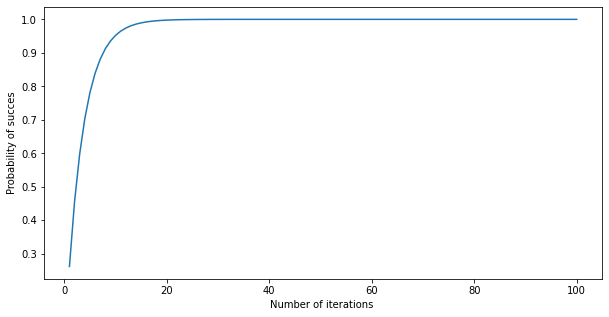

In [61]:
E = 0.20
p = 0.95
s = 6
e=math.e
p1 = 1-p
p2 = math.log(p1,e)
E1 = 1- (1-E)**s
E2 = math.log(E1,e)
T = math.log(p1,E1)

if T-int(T)!=0:
    T = T-(T-int(T))+1
print("minimum number of iteration :",int(T),"\n")
T = np.linspace(1, 100, 100) 
p = 1-e**(T*E2)
fig = plt.figure(figsize = (10, 5)) 
plt.plot(T, p)
plt.xlabel("Number of iterations ")
plt.ylabel("Probability of succes")
plt.show() 

T comes out to be 10

# ZHANGS METHOD FOR CAMERA CALIBRATION

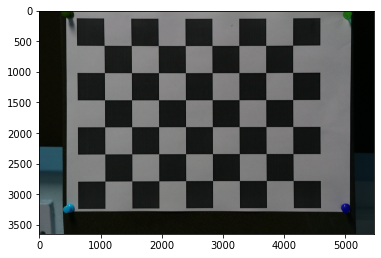

In [12]:
##################Zhangs method##################
fig = plt.figure(figsize=(6,6))
IMAGES_FOLDER_PATH = "../calibration-data/"
images =["IMG_5456.JPG", "IMG_5457.JPG", "IMG_5458.JPG", "IMG_5459.JPG", "IMG_5460.JPG",
        "IMG_5461.JPG", "IMG_5462.JPG", "IMG_5463.JPG", "IMG_5464.JPG", "IMG_5465.JPG",
        "IMG_5466.JPG", "IMG_5467.JPG", "IMG_5468.JPG", "IMG_5469.JPG", "IMG_5470.JPG"]

img_s = []
for i in images:
    img_s.append(cv2.imread(os.path.join(IMAGES_FOLDER_PATH,i)))
img_s = np.array(img_s)
plt.imshow(img_s[0])    

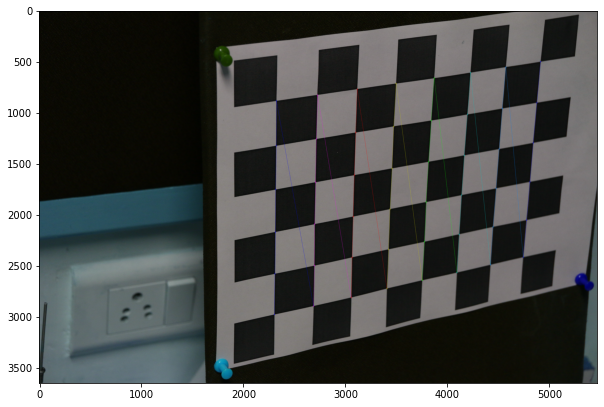

In [20]:
ret, corners = cv2.findChessboardCorners(img_s[9],(6, 8))
corners = corners.reshape(-1,2)
img1 = img_s[9].copy()
cv2.drawChessboardCorners(img1, (6, 8), corners, ret)
plt.figure(figsize=(10,10))
plt.imshow(img1)

In [14]:
WorldPoints = [] # 3d point in real world space
ImgPoints = [] # 2d points in image plane.
for i in range(len(img_s)):
    ret,corners = cv2.findChessboardCorners(img_s[i],(6,8))
    corners=corners.reshape(-1,2)
    objpoints = np.zeros((6*8,3), np.float32)
    objpoints[:,:2] = np.mgrid[0:6,0:8].T.reshape(-1,2)
    #print(corners.shape)
    #print(objpoints.shape)
    if ret == True:
        ImgPoints.append(corners)
        WorldPoints.append(objpoints)
W_p = np.array(WorldPoints)
I_p = np.array(ImgPoints)
W_p = W_p.reshape(-1,3)
I_p = I_p.reshape(-1,2)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(WorldPoints,ImgPoints, (img_s[1].shape[1],img_s[1].shape[0]), None, None)      

In [49]:
print("Camera matrix :\n",np.dot(mtx,I))
print("\n")
print("Distortion :\n",dist)
print("\n")
print("Rotation vetor :\n",rvecs[0])
print("\n")
print("Translation  :\n",tvecs[0])
print("\n")
print("Reprojection error :",ret,"\n")

Camera matrix :
 [[-1.36634770e+04  0.00000000e+00  3.33653557e+03]
 [ 0.00000000e+00 -1.36813826e+04  1.49660054e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Distortion :
 [[ 9.52128779e-02  1.01092832e+01 -1.52798104e-02  2.87212972e-02
  -1.60590110e+02]]


Rotation vetor :
 [[-0.05108578]
 [-0.03039049]
 [ 1.56728564]]


Translation  :
 [[ 1.84614461]
 [-2.07051919]
 [31.24010544]]


Reprojection error : True 



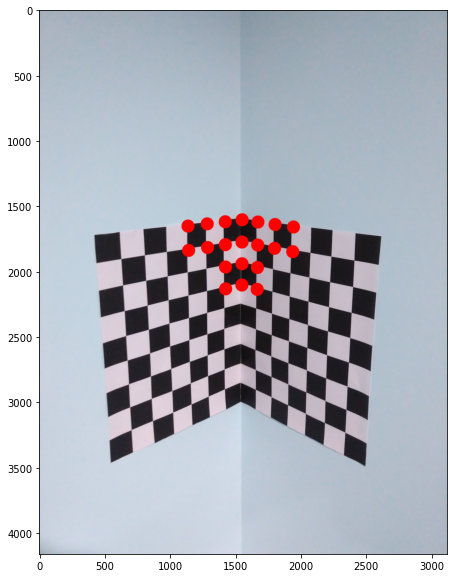

In [18]:
def plotImgPoints(image, points):
    for i in range(len(points)):
        for j in range(len(points[i])):
            points[i][j] = int(points[i][j])  
#     print(points)
    img = image.copy()
    for (x, y) in points:
        if x < 0 or x >= img.shape[0] or y < 0 or y >= img.shape[1]:
            continue
        img = cv2.circle(img, (int(x), int(y)), 50, (255, 0, 0), -1)
    return img
imge = cv2.imread('../calibration-data/calib-object.jpg')
prjctn_matrix = Dlt(X_world, x_image)

pred_points = predictImgpoint(prjctn_matrix, X_world)
img = plotImgPoints(imge, pred_points)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()


# DIY

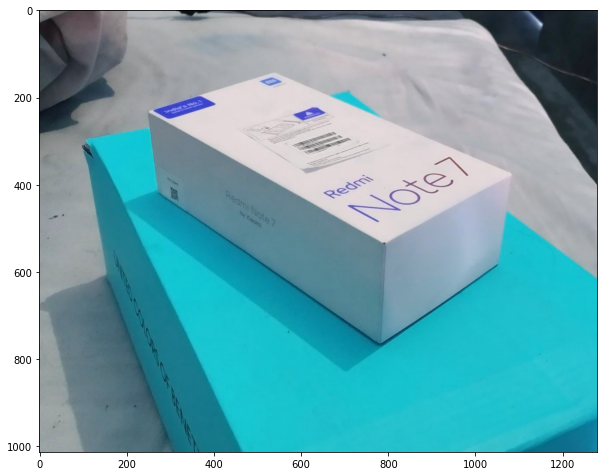



Projection Matrix (P): 
 [[ 1.59820788e-01 -6.78868993e-03 -4.58197358e-02  7.59686144e-01]
 [ 1.93799011e-02 -4.26441055e-03 -4.02957961e-02  6.27033044e-01]
 [ 1.33742029e-04  5.73963045e-05 -5.64375421e-05  8.74990833e-04]]


Camera Matrix (K) : 
 [[-437.58143705  -95.22688967  967.35684022]
 [   0.         -216.39786879  189.65993155]
 [   0.            0.            1.        ]]


Rotation Matrix (R) : 
 [[ 0.48427366 -0.81464239  0.31911878]
 [-0.17719795 -0.44850661 -0.87603807]
 [ 0.85678463  0.36769497 -0.3615529 ]]


Camera Center (C) : 
 [-0.33037083  0.60656113 15.33767599]



Reconstruction error from original points :  71.285632105342
Reconstruction error from Normalised points of cameraImg :  2.2576776624076667
Reconstruction error for part (C) :  1154.7792154774716



iteration ...........( 4 )
Calculated error which are less than threshold error: 1.0447303622976032
iteration ...........( 7 )
Calculated error which are less than threshold error: 0.8265205471209094
ite

In [59]:
###################################  4 ###################################
myImg = cv2.imread("../images/myCamImg.jpeg")

plt.figure(figsize=(10,10))
plt.imshow(myImg)
plt.show()

MyCimg_points = [[943,336], [911,335], [712,449], [786,767], [1054,582], [1085,379],[273,419],[250,235],[540,142]]
MyCimg_points = np.array(MyCimg_points)

MyCworld_points = [[7.7,3,5], [6.5,3,5], [1,3,5], [0,0,0], [0,0,5], [8.5,0,0],[0,0,17],[0,17,5],[5,17,8.5]]
MyCworld_points = np.array(MyCworld_points)

# print(MyCimg_points,MyCworld_points)

P_myC = Dlt(MyCworld_points,MyCimg_points)

K_myC,R_myC,C_myC = DecomposeProjectionMatrix(P_myC)
print("\n")
print("Projection Matrix (P): \n",P_myC)
print("\n")
print("Camera Matrix (K) : \n",np.dot(K_myC,I))
print("\n")
print("Rotation Matrix (R) : \n",R_myC)
print("\n")
print("Camera Center (C) : \n",C_myC)
print()
Img_predicted_myC = predictImgpoint(P_myC,MyCworld_points)
min_errC=calMSe(Img_predicted_myC,MyCimg_points)
print("\n")
print("Reconstruction error from original points : ",min_errC)

norm_Camimg_points,T_m = NormalizationImg(MyCimg_points)
norm_Camworld_points,U_m = NormalizationWrd(MyCworld_points)
p_Camnorm = Dlt(norm_Camworld_points,norm_Camimg_points)
Norm_Camimg_predicted = predictImgpoint(p_norm,norm_world_points)
error_Camnorm = calMSe(Norm_Camimg_predicted,norm_Camimg_points)
print("Reconstruction error from Normalised points of cameraImg : ",error_Camnorm)

T_minv = np.linalg.inv(T_m)
DnormP = np.dot(np.dot(T_minv,p_norm),U_m)
pred_xIm = predictImgpoint(Dnorm_P,MyCworld_points)
error_Dnorm = calMSe(pred_xIm,MyCimg_points)
print("Reconstruction error for part (C) : ",error_Dnorm)
print()
print("\n")

optimal_P_myC,optimal_K_myC,optimal_R_myC,optimal_C_myC,min_err_myCR=RANSAC(MyCworld_points,MyCimg_points,itr,err_thresh)       
print("Projection Matrix (P): \n", optimal_P_myC)
print("\n")
print("Camera Matrix (K) : \n",np.dot(optimal_K_myC,I))
print("\n")
print("Rotation Matrix (R) : \n",optimal_R_myC)
print("\n")
print("Camera Center (C) : \n",optimal_C_myC)
print("\n")
print("Minimum error : ",min_err_myCR)



1.Camera Calibration using RANSAC (With 6 points that are selected from the given world and image point ) and Normal DLT with all(10 points) in both cases we get the reconostruction almost same .



2.This experiment are also with the case of normalise input.In this case the reconstruction error are slightly varry and after that it checked with denomalised P matrix that are almost same as with original input point.